In [ ]:
path = 'sample_data/tomato-early-blight-11.jpg'

SLIC SEGMENTATION

(180, 180)


<Figure size 640x480 with 0 Axes>

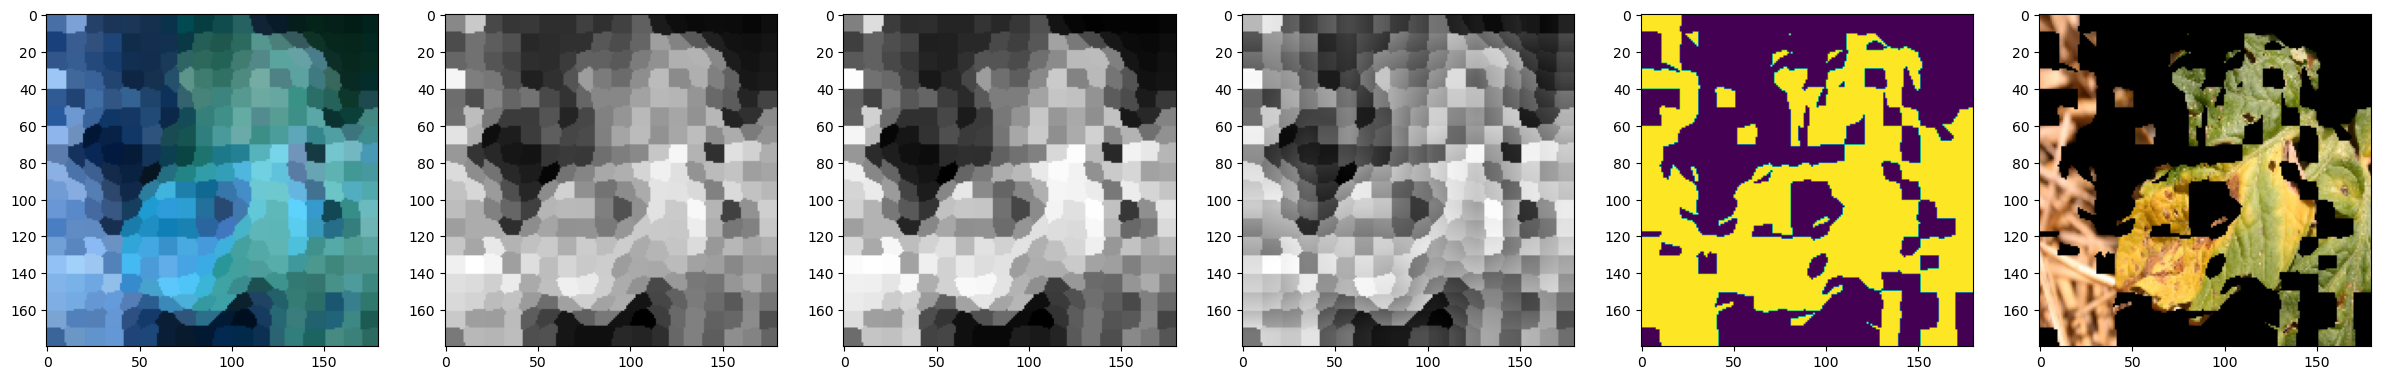

In [ ]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io,color
import matplotlib.pyplot as plt
import cv2
import numpy as np

# load the image and convert it to a floating point data type
# path = 'dataset/train/Leaf_Mold/0adab1d4-5696-4cd8-8453-3931b70e856d___Crnl_L.Mold 8689.JPG'
# path = 'dataset/train/healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'
# image = img_as_float(io.imread(path))
image = cv2.imread(path)
image = cv2.resize(image, (180,180))

numSegments = 300
segments = slic(image, n_segments = numSegments, sigma = 10, compactness=10)
fig = plt.figure("Superpixels -- %d segments" % (numSegments))

fig, axs = plt.subplots(1, 6, figsize=(30,15))
# ax = fig.add_subplot(1, 3, 3)

# show the plots
# segments = mark_boundaries(image, segments, mode='inner')
# segments = segments[:,:,np.newaxis]
# ax.imshow(segments)
print(segments.shape)

# convert all superpixels to mean color
out = color.label2rgb(segments, image, kind='avg')
# ax = fig.add_subplot(, 2, 2)
axs[0].imshow(out)

gray = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
axs[1].imshow(gray, cmap='gray')

# contrast optimization
histeq = cv2.equalizeHist(gray)
axs[2].imshow(histeq, cmap='gray')

clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
gray = clahe.apply(gray)
axs[3].imshow(gray, cmap='gray')

binary = cv2.inRange(gray, 0, 255)
# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours = cv2.drawContours(gray, contours, -1, (0, 255, 0), 3)
# print(contours.shape)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
axs[4].imshow(thresh)
final = cv2.bitwise_and(image, image, mask=thresh)
axs[5].imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))


plt.show()

MEAN SHIFT ON RESULT

shape of labels : 32400
(11, 3)
number of estimated clusters : 11


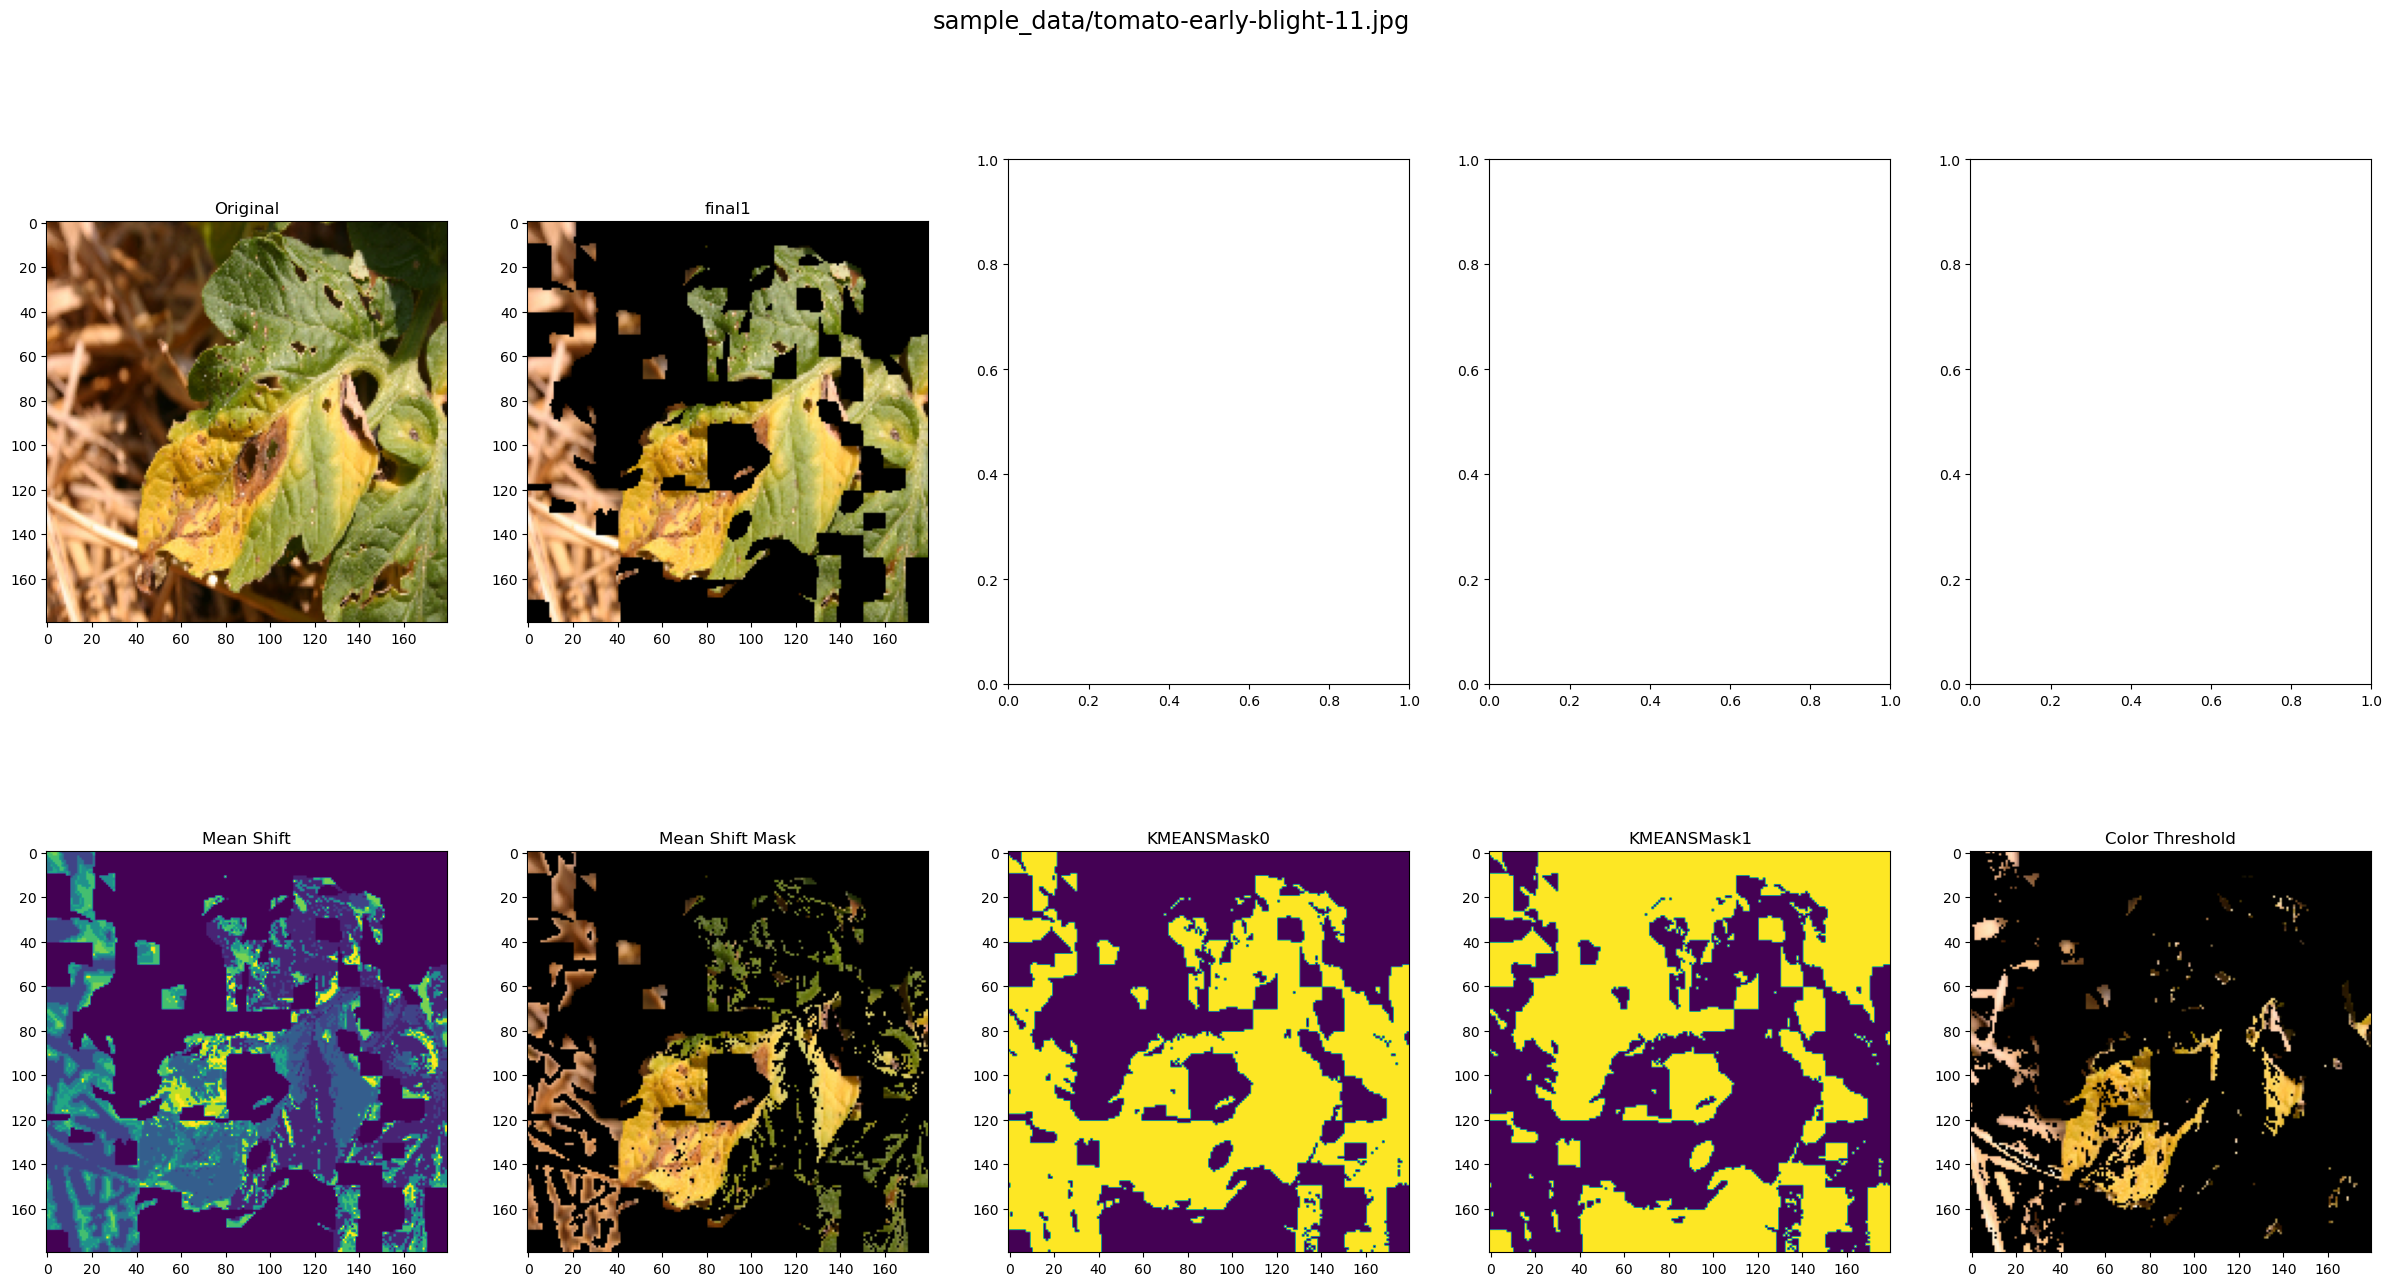

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

img = final.copy()
# final1 = cv2.bitwise_and(img, img, mask=mask1_opening)
final1 = img

fig, axs = plt.subplots(2, 5, figsize=(30,15))
fig.suptitle(path, size='xx-large')
# plt.subplot(1, 9, 1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Original")
axs[0][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0][0].set_title('Original')
# plt.subplot(1, 9, 5), plt.imshow(cv2.cvtColor(final1, cv2.COLOR_BGR2RGB), ), plt.title("Final1")
axs[0][1].imshow(cv2.cvtColor(final1, cv2.COLOR_BGR2RGB))
axs[0][1].set_title('final1')


# MEAN SHIFT ---------------------------------------------------------------------------------------------------
from sklearn.cluster import MeanShift, estimate_bandwidth
# plt.imshow(mask1)
# saving the image shape
shape = final1.shape
# reshaping image 
reshape_img = np.reshape(final1, [-1, 3])
bandwidth = estimate_bandwidth(reshape_img, quantile=0.1, n_samples=100)
bandwidth
msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msc.fit(reshape_img)
print("shape of labels : %d" % msc.labels_.shape)
print( msc.cluster_centers_.shape)
print("number of estimated clusters : %d" % len(np.unique(msc.labels_)))
labels = msc.labels_
result_image = np.reshape(labels, shape[:2])
clusters = result_image.copy()
_, result_image = cv2.threshold(result_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)

# plt.subplot(1, 9, 6), plt.imshow(clusters), plt.title("Mean Shift")
axs[1][0].imshow(clusters)
axs[1][0].set_title('Mean Shift')
mask = cv2.inRange(clusters.astype(np.uint8), len(np.unique(msc.labels_))/4, len(np.unique(msc.labels_)))
final = cv2.erode(mask, np.ones((9,9), np.uint8), iterations = 1)
final = cv2.bitwise_and(final1, final1, mask=mask)
# final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)

# # then, finally color threshold the segmented leaf
# final_lab = final.copy()
# final_lab = cv2.cvtColor(final_lab, cv2.COLOR_BGR2LAB)
# leaf_mask = cv2.inRange(final_lab[:,:,1], 110, 100+128)
# final = cv2.bitwise_and(final, final, mask=leaf_mask)
# final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)

# plt.subplot(1, 9, 7), plt.imshow(final), plt.title("Mean Shift Mask")
axs[1][1].imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
axs[1][1].set_title('Mean Shift Mask')
# # plt.show()


# K MEANS ---------------------------------------------------------------------------------------------------
# Reshape image to 2D array of pixels
final1_hsv = final1.copy()
final1_hsv = cv2.cvtColor(final1, cv2.COLOR_BGR2HSV)
pixel_values = final1.reshape((-1,3))
# Convert to float32
pixel_values = np.float32(pixel_values)
# Define k (number of clusters)
k = 2
# Define criteria and perform kmeans clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2) #or 10, 1.0
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
# Convert back to 8-bit
centers = np.uint8(centers)
# Reshape labels to original image shape
labels = labels.reshape((img.shape[0], img.shape[1]))
# Create mask for foreground and background
mask0 = (labels == 0)
mask1 = (labels == 1)
background = cv2.bitwise_and(img, img, mask=mask1.astype(np.uint8))
foreground = cv2.bitwise_and(img, img, mask=mask0.astype(np.uint8))

# plt.subplot(1, 9, 8), plt.imshow(mask0), plt.title("Mask 0")
axs[1][2].imshow(mask0)
axs[1][2].set_title('KMEANSMask0')
# plt.subplot(1, 9, 9), plt.imshow(mask1), plt.title("Mask 1")
axs[1][3].imshow(mask1)
axs[1][3].set_title('KMEANSMask1')


# COLOR THRESHOLD TO GET DISEASE --------------------------------------------------------------------------------------
leaf = final1.copy()
# remove shadows
leaf = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
leaf_shadow_mask = cv2.inRange(leaf[:,:,0], 50*2.55, 100*2.55)
leaf = cv2.bitwise_and(final1, final1, mask=leaf_shadow_mask)
# remove lesions
leaf_rgb = leaf.copy()
leaf_rgb = cv2.cvtColor(leaf_rgb, cv2.COLOR_BGR2RGB)
leaf = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
# leaf_mask = cv2.inRange(leaf[:,:,1], -8+128, 100+128)
leaf_mask = cv2.inRange(cv2.equalizeHist( leaf[:,:,1] ), 110, 100+128)

diseased = cv2.bitwise_and(final1, final1, mask=leaf_mask)
axs[1][4].set_title('Color Threshold')
axs[1][4].imshow(cv2.cvtColor(diseased, cv2.COLOR_BGR2RGB))
# axs[1][4].imshow(cv2.bitwise_and(leaf_rgb, leaf_rgb, mask=leaf_mask))

plt.show()


code to perform mean shift clustering on an image, then assign each cluster to its mean color

uses mean shift to separate foreground from background, assigns each cluster to mean color, then performs otsu on the grayscale image

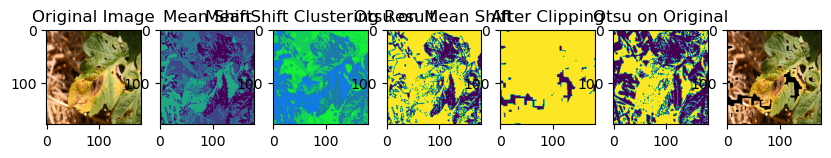

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import cv2

# Read the image and resize it
img = cv2.imread(path)
img = cv2.resize(img, (180, 180))
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Get the image shape
rows, cols, channels = img.shape

# Reshape the image
img_reshape = img.reshape(rows * cols, channels)

# Estimate bandwidth for MeanShift
bandwidth = estimate_bandwidth(img_reshape, quantile=0.1)

# Perform MeanShift clustering
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(img_reshape)

# Get the cluster labels and cluster centers
labels = ms.labels_
centers = ms.cluster_centers_

# Assign each pixel to its mean color
result_image = np.zeros_like(img)
for i in range(rows):
    for j in range(cols):
        label = labels[i * cols + j]
        result_image[i, j, :] = centers[label]

# Plot the original and result images side by side
meanshift = np.reshape(labels, shape[:2])
fig, axs = plt.subplots(1, 7, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(meanshift)
axs[1].set_title('Mean Shift')
axs[2].imshow(result_image)
axs[2].set_title('MeanShift Clustering Result')

# result_image = cv2.cvtColor(result_image, cv2.COLOR_HSV2BGR)

ret, thresh = cv2.threshold(cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_OTSU)
axs[3].imshow(thresh)
axs[3].set_title('Otsu on Mean Shift')
# ret, thresh1 = cv2.threshold(result_image[:,:,0], 0, 255, cv2.THRESH_OTSU)
# ret, thresh2 = cv2.threshold(result_image[:,:,1], 0, 255, cv2.THRESH_OTSU)
# ret, thresh3 = cv2.threshold(result_image[:,:,2], 0, 255, cv2.THRESH_OTSU)
# thresh = thresh1

clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
claheopt = clahe.apply(result_image[:,:,1])
ret, thresh_clip = cv2.threshold(claheopt, 0, 255, cv2.THRESH_OTSU)
thresh_clip = cv2.dilate(thresh_clip, kernel=np.ones((10,10), np.uint8()))

axs[4].imshow(thresh_clip)
axs[4].set_title('After Clipping')

histeq = cv2.equalizeHist(gray)
ret, thresh_original = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_OTSU)

# Apply Canny edge detection
edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 100, 200)

axs[5].imshow(thresh_original)
axs[5].set_title('Otsu on Original')

rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
final = cv2.bitwise_and(rgb, rgb, mask=thresh_clip)
axs[6].imshow(final)

plt.show()


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read the image and resize it
img = cv2.imread(path)
img = cv2.resize(img, (180, 180))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reshape the image to a 2D array of pixels and convert to float32
pixel_values = img.reshape((-1, 3)).astype(np.float32)

# Define k (number of clusters)
k = 7

# Define criteria and perform kmeans clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2) #or 10, 1.0
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reshape labels to original image shape
labels = labels.reshape((img.shape[0], img.shape[1]))

# Create a mask for each cluster
masks = [labels == i for i in range(k)]

# Apply each mask to the original image and compute the mean color for each cluster
mean_colors = np.zeros((k, 3))
for i in range(k):
    masked_pixels = img[masks[i]]
    mean_colors[i] = np.mean(masked_pixels, axis=0)

# Assign each pixel to its mean color
result_img = np.zeros_like(pixel_values)
for i in range(k):
    mask = masks[i].reshape(-1, 1)
    result_img += mask * mean_colors[i]

# Reshape the result back to the original image shape
result_img = result_img.reshape(img.shape).astype(np.uint8)

# Plot the original and result images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
axs[0].set_title('Original')
# im = axs[1].imshow(cv2.cvtColor(result_img, cv2.COLOR_HSV2RGB),cmap='hsv')
# fig.colorbar(im,ax=axs[1])

axs[1].imshow(cv2.cvtColor(result_img, cv2.COLOR_HSV2RGB))
axs[1].set_title('Segmented')
plt.show()


: 